In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

FTRAIN ='training.csv'
FTEST = 'test.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [3]:
#  I changed the X dimension structure to have (Nsample, Nrows in frame, N columns in frame, 1) in load2d.
def load2d(test=False,cols=None):

    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    y = re[1]

    return X, y

## Benchmark models

## A Fully connected model

In [4]:
%time
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout, Conv2D, MaxPool2D, LeakyReLU

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 30)                614

In [5]:
X,y=load2d()
print(X.shape)
print(y.shape)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer='Adam', loss='mse', metrics=['mae','accuracy'])
history=model.fit(X, y, epochs=200 ,batch_size=128,validation_data=(X_val,y_val),callbacks=[earlyStopping, rlp])

Epoch 1/200
17/17 [==============================] - 12s 277ms/step - loss: 0.3289 - mae: 0.3362 - accuracy: 0.2505 - val_loss: 1326.1799 - val_mae: 29.7094 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 3s 156ms/step - loss: 0.0193 - mae: 0.1051 - accuracy: 0.4579 - val_loss: 75.2205 - val_mae: 6.8453 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 3s 156ms/step - loss: 0.0079 - mae: 0.0687 - accuracy: 0.5734 - val_loss: 108.7528 - val_mae: 8.3216 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 3s 156ms/step - loss: 0.0052 - mae: 0.0559 - accuracy: 0.6341 - val_loss: 51.1781 - val_mae: 5.6790 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 3s 156ms/step - loss: 0.0041 - mae: 0.0496 - accuracy: 0.6776 - val_loss: 15.3389 - val_mae: 3.0312 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 6/200
17/17 [==============================]

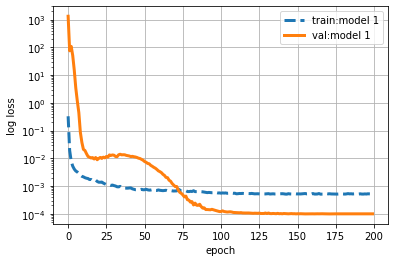

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plot_loss(history.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [9]:
X_test, _ = load2d(test=True)
y_test = model.predict(X_test)

ImageId    1783
Image      1783
dtype: int64


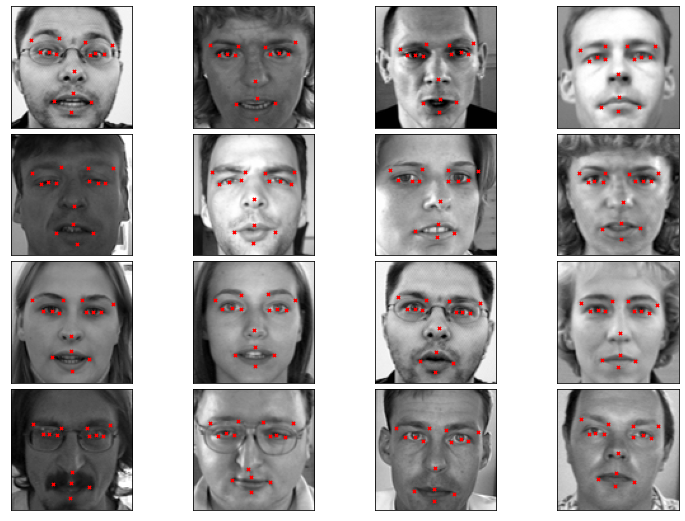

In [10]:
#converting the images back to 96*96 pixels so i can check the performance of my model on the image dataset

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')


fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

In [11]:
from keras.models import load_model
# import h5py
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
model = load_model('my_model.h5')

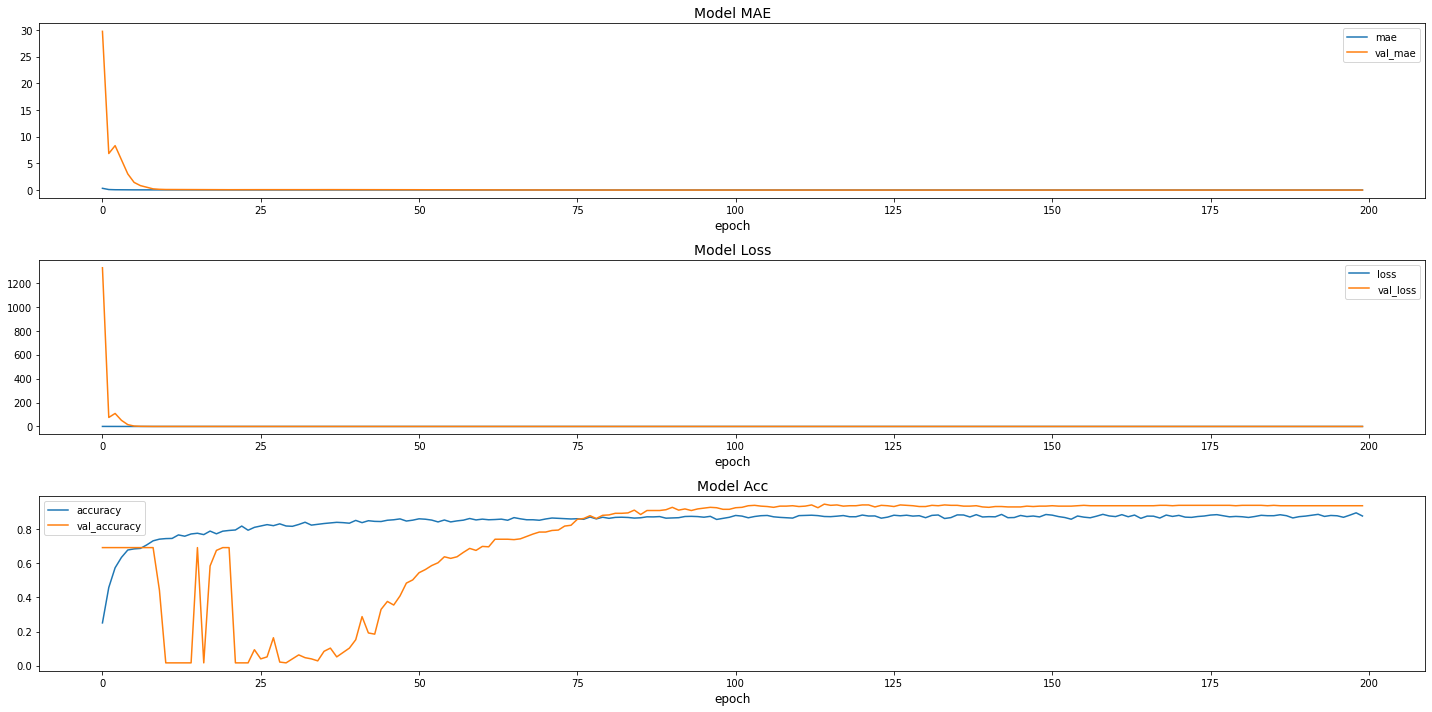

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['mae','val_mae']].plot(ax=ax[0])
df[['loss','val_loss']].plot(ax=ax[1])
df[['accuracy','val_accuracy']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=14)
ax[0].set_xlabel('epoch', fontsize=12)
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('epoch', fontsize=12)
ax[2].set_title('Model Acc', fontsize=14)
ax[2].set_xlabel('epoch', fontsize=12)
fig.tight_layout()
plt.savefig('D:\\aaa')

In [13]:
# #Deleting these as i will use a new structure

del X, y, X_test, y_test

## Convolutional Neural Network



In [14]:
X,y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [15]:
print(X.shape)
print(y.shape)

(2140, 96, 96, 1)
(2140, 30)


In [16]:
from keras.layers import MaxPooling2D, Conv2D , Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization


In [17]:
def CNN():
    model2 = Sequential()

    model2.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(96,96,1)))
    model2.add(Dropout(0.1))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(32, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(Dropout(0.2))
    model2.add(BatchNormalization())

    model2.add(Conv2D(64, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(128, 3, 3,activation="relu",padding='same'))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(Dropout(0.4))
    model2.add(BatchNormalization())

    model2.add(Flatten())

    model2.add(Dense(500, activation="relu"))
    model2.add(Dropout(0.1))

    model2.add(Dense(128, activation="relu"))
    model2.add(Dropout(0.1))

    model2.add(Dense(30))


    model2.summary()
    model2.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae','accuracy'])
    return(model2)

In [18]:
model2 = CNN()
hist2 = model2.fit(X, y, epochs=200,batch_size=128, validation_split=0.2,verbose=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        80        
                                                                 
 dropout_1 (Dropout)         (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 32)          12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)        

In [19]:
print(hist2.history)

{'loss': [0.15897580981254578, 0.04476455971598625, 0.028668537735939026, 0.021760348230600357, 0.01802370324730873, 0.0151932742446661, 0.013999707996845245, 0.012922012247145176, 0.011938342824578285, 0.011559505015611649, 0.010720902122557163, 0.01051220204681158, 0.010125438682734966, 0.009497950784862041, 0.00952015072107315, 0.00869705155491829, 0.008453191258013248, 0.008112162351608276, 0.008486483246088028, 0.007974040694534779, 0.007625564932823181, 0.007647627964615822, 0.007452563848346472, 0.007322106976062059, 0.0070741139352321625, 0.00685256440192461, 0.0067340838722884655, 0.0069229272194206715, 0.006802017334848642, 0.006535292603075504, 0.006522982846945524, 0.006230777129530907, 0.006267488468438387, 0.006255532149225473, 0.006112012546509504, 0.005952921230345964, 0.006007478106766939, 0.005940005648881197, 0.005760841071605682, 0.005863597616553307, 0.005703967995941639, 0.00563729926943779, 0.005652346182614565, 0.005446459166705608, 0.005492764990776777, 0.00545

In [20]:
hist2.history

{'accuracy': [0.11273364722728729,
  0.20735980570316315,
  0.3317756950855255,
  0.3960280418395996,
  0.4637850522994995,
  0.4807243049144745,
  0.46787384152412415,
  0.5163551568984985,
  0.5543224215507507,
  0.5467289686203003,
  0.5619158744812012,
  0.5473130941390991,
  0.5566588640213013,
  0.572429895401001,
  0.5689252614974976,
  0.6028037667274475,
  0.6022196412086487,
  0.6068925261497498,
  0.5922897458076477,
  0.6045560836791992,
  0.6080607771873474,
  0.6098130941390991,
  0.6355140209197998,
  0.625,
  0.6133177280426025,
  0.6431074738502502,
  0.6442757248878479,
  0.625,
  0.6460280418395996,
  0.6483644843101501,
  0.663551390171051,
  0.6623831987380981,
  0.6547897458076477,
  0.6617990732192993,
  0.6688084006309509,
  0.6623831987380981,
  0.6699766516685486,
  0.6822429895401001,
  0.6799065470695496,
  0.6915887594223022,
  0.6968457698822021,
  0.6921728849411011,
  0.6822429895401001,
  0.6810747385025024,
  0.6822429895401001,
  0.6950934529304504,
 

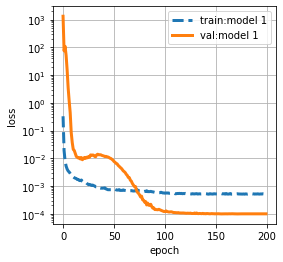

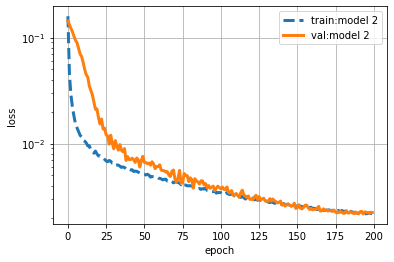

In [22]:
# Comparing model1 and model2
plt.figure(figsize=(4,4))
plot_loss(history.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plot_loss(hist2.history,"model 2",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

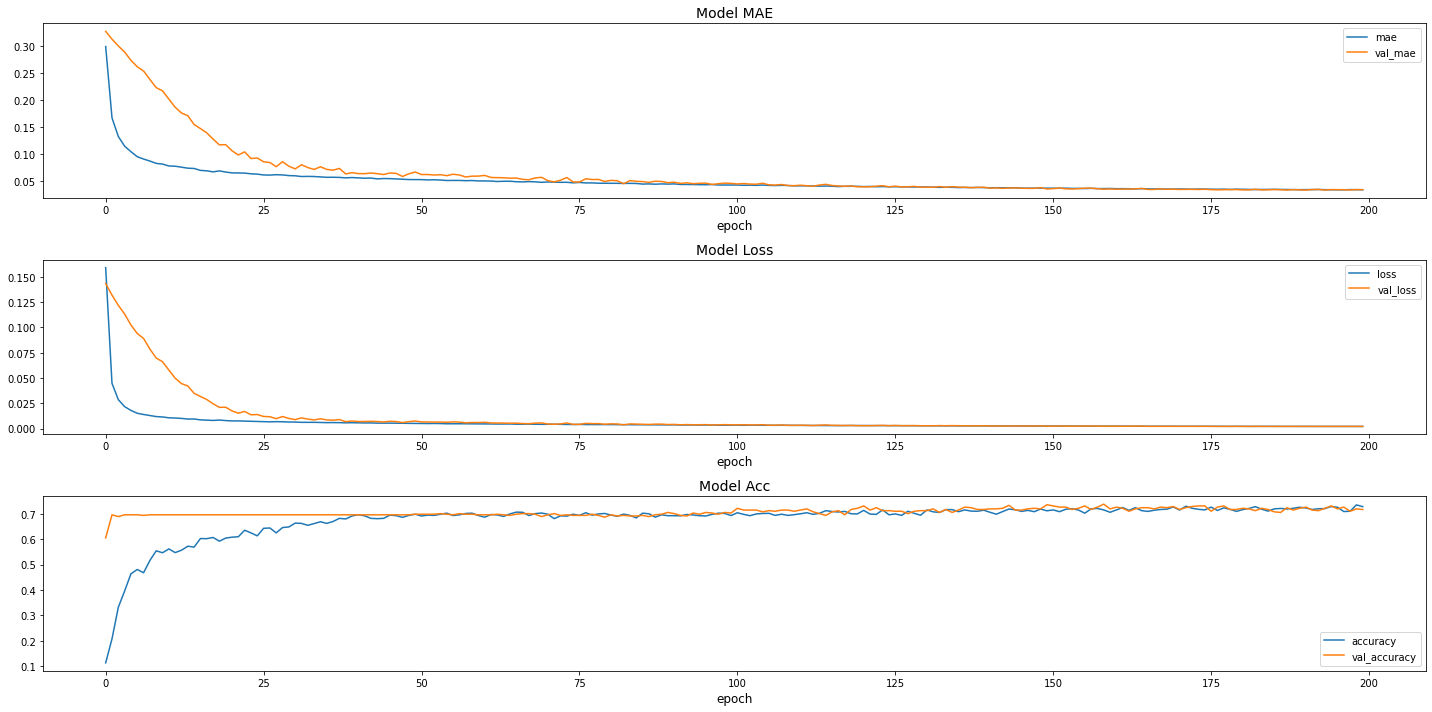

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(hist2.history)
df[['mae','val_mae']].plot(ax=ax[0])
df[['loss','val_loss']].plot(ax=ax[1])
df[['accuracy','val_accuracy']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=14)
ax[0].set_xlabel('epoch', fontsize=12)
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('epoch', fontsize=12)
ax[2].set_title('Model Acc', fontsize=14)
ax[2].set_xlabel('epoch', fontsize=12)
fig.tight_layout()
plt.savefig('D:\\aaa')

In [27]:
sample1,_ = load2d(test=True)
sample2,_ = load2d(test=True)
y_pred1 = model.predict(sample1)
y_pred2 = model2.predict(sample2)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


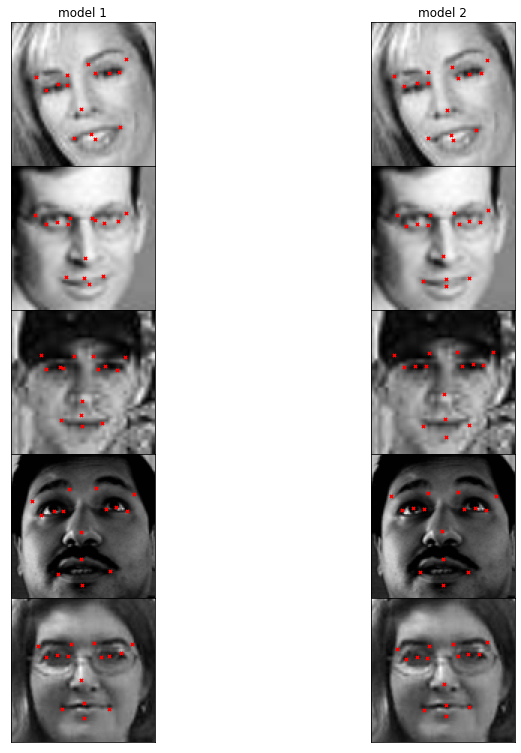

In [28]:
#Comparing model1 and model2 on images

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.001,wspace=0.001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 5
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(sample2.shape[0])
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])        
    plot_sample(sample1[ipic],y_pred1[ipic],ax)
    if count < 3:
        ax.set_title("model 1")
        
    count += 1
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])  
    plot_sample(sample2[ipic],y_pred2[ipic],ax)
    if count < 3:
        ax.set_title("model 2")
    count += 1
plt.show()

In [25]:
model2.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
model2 = load_model('my_model2.h5')